In [1]:
cd ..

C:\Users\Nghia\PycharmProjects\ECML\Refactor


In [2]:
from pprint import pprint

import numpy as np
import tensorflow as tf
import time
from collections import Counter

from load_datasets import mnist
from metrics import metrics
from models.AE1SVM import AEOneClassSVM

import matplotlib
import matplotlib.pyplot as plt

c:\users\nghia\anaconda2\envs\tf36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
tf.set_random_seed(2018)

x_train, y_train, x_test, y_test = mnist(random_state=3)

counter = Counter(y_train)
print('Anomalies ratio:', 100*counter[-1]/(counter[1]+counter[-1]), '%')

c:\users\nghia\anaconda2\envs\tf36\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Anomalies ratio: 1.682935038707506 %


In [4]:
batch_size = 32
data_input = tf.placeholder(tf.float32, shape=[None, 784])

In [5]:
cae1svm = AEOneClassSVM(data_input, batch_size, 'test_conv1', None, 0.35, 1e4, 3.0, 1000, convolutional=True,
                        full_op=tf.train.AdamOptimizer(1e-3), ae_op=tf.train.AdamOptimizer(1e-2),
                        svm_op=tf.train.AdamOptimizer(1e-4))

Combined train
Epoch: 1 Loss: 0.3387542385639305 ( 1.1975274809038386e-05 x 10000.0 + 0.2190032825450711 ) AUROC: 0.5120267031838411
Epoch: 2 Loss: 0.2730402270778989 ( 8.820015993514715e-06 x 10000.0 + 0.1847629502179927 ) AUROC: 0.5340260184868196
Epoch: 3 Loss: 0.23092167564451152 ( 7.499537883042406e-06 x 10000.0 + 0.15590947888508183 ) AUROC: 0.5652687435809655
Epoch: 4 Loss: 0.19856012088206831 ( 6.700976579649125e-06 x 10000.0 + 0.1314879590435407 ) AUROC: 0.4986648408079425
Epoch: 5 Loss: 0.17201699764389095 ( 6.131688023167241e-06 x 10000.0 + 0.11075913805786666 ) AUROC: 0.5612324546388223
Epoch: 6 Loss: 0.14958017837796617 ( 5.6629829316859856e-06 x 10000.0 + 0.09315578546719855 ) AUROC: 0.5756110920917494
Epoch: 7 Loss: 0.13210914737646204 ( 5.381610664563804e-06 x 10000.0 + 0.07819953232813026 ) AUROC: 0.5667374186922287
Epoch: 8 Loss: 0.11649425484764178 ( 5.09630903747097e-06 x 10000.0 + 0.06550255065733077 ) AUROC: 0.5692057514549812
Epoch: 9 Loss: 0.10335573384513842 ( 

Epoch: 68 Loss: 0.03101973660423153 ( 3.1187933518885763e-06 x 10000.0 + -7.516195861549339e-05 ) AUROC: 0.7970694967476891
Epoch: 69 Loss: 0.031487263641306065 ( 3.1636250451412798e-06 x 10000.0 + -7.840416239632857e-05 ) AUROC: 0.7983224922971585
Epoch: 70 Loss: 0.03143169309345811 ( 3.1597809493040163e-06 x 10000.0 + -7.868964677706025e-05 ) AUROC: 0.7852687435809654
Epoch: 71 Loss: 0.03371561693045797 ( 3.4054635937107168e-06 x 10000.0 + -7.774894264000348e-05 ) AUROC: 0.7850154056829853
Epoch: 72 Loss: 0.032965527524534036 ( 3.3073756719670764e-06 x 10000.0 + -7.876206110399285e-05 ) AUROC: 0.7560150633344744
Epoch: 73 Loss: 0.03038118375908522 ( 3.052778223555163e-06 x 10000.0 + -8.563363804876584e-05 ) AUROC: 0.7908901061280383
Epoch: 74 Loss: 0.029403083053994604 ( 2.9520562043377786e-06 x 10000.0 + -8.539828897846624e-05 ) AUROC: 0.7598630605956863
Epoch: 75 Loss: 0.028366068323546892 ( 2.8383944124655465e-06 x 10000.0 + -8.549215977378905e-05 ) AUROC: 0.8129441971927422
Epoch

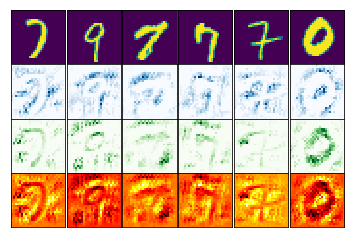

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()

    # Autoencoder-OneclassSVM
    t0 = time.time()
    #cae1svm.fit_ae(sess, x_train, epochs=20, shuffle=True)
    cae1svm.fit(sess, x_train, x_train, y_train, epochs_1=86, epochs_2=0)
    print('Train time:', time.time() - t0)

    saver.save(sess, './trained_MNIST.ckpt')
    
    t0 = time.time()
    out_y = cae1svm.predict(sess, x_test)
    print('Test time:', time.time() - t0)

    pprint(metrics(y_test, out_y))

    x_train_encoded = cae1svm.encode(sess, x_train)
    x_test_encoded = cae1svm.encode(sess, x_test)

    x_train_rff = cae1svm.encode_rff(sess, x_train)
    x_test_rff = cae1svm.encode_rff(sess, x_test)
    
    normal = x_test[np.where(y_test == 1)]
    anomalies = x_test[np.where(y_test == -1)]
    
    gs = matplotlib.gridspec.GridSpec(4, 6)
    gs.update(wspace=0, hspace=0)
    for n in range(6):
        a = anomalies[n]
        g = sess.run(cae1svm.gradient, {data_input: [anomalies[n]]})
        g = np.reshape(g, (784, len(g)))

        splt = plt.subplot(gs[n])
        splt.imshow(np.reshape(anomalies[n], (28, 28)))
        splt.set_xticks([])
        splt.set_yticks([])
        
        splt = plt.subplot(gs[n+6])
        splt.imshow(np.maximum(0, np.reshape(g, (28, 28))), cmap='Blues')
        splt.set_xticks([])
        splt.set_yticks([])

        splt = plt.subplot(gs[n+12])
        splt.imshow(np.maximum(0, -np.reshape(g, (28, 28))), cmap='Greens')
        splt.set_xticks([])
        splt.set_yticks([])
        
        splt = plt.subplot(gs[n+18])
        splt.imshow(np.reshape(g, (28, 28)), cmap='hot')
        splt.set_xticks([])
        splt.set_yticks([])  


In [11]:
from sklearn.svm import OneClassSVM

# Train conventional OCSVM
print('OCSVM-RBF')
libsvm = OneClassSVM(nu=0.2, verbose=True, shrinking=True)
t0 = time.time()
libsvm.fit(x_train_encoded)
print('Train time:', time.time() - t0)

t0 = time.time()
out_y = libsvm.predict(x_test_encoded)
print('Test time:', time.time() - t0)
pprint(metrics(y_test, out_y))

print('OCSVM-Linear')
libsvm = OneClassSVM(nu=0.12, verbose=True, shrinking=True, kernel='linear')
t0 = time.time()
libsvm.fit(x_train_encoded)
print('Train time:', time.time() - t0)

t0 = time.time()
out_y = libsvm.predict(x_test_encoded)
print('Test time:', time.time() - t0)
pprint(metrics(y_test, out_y))

OCSVM-RBF
[LibSVM]Train time: 0.5581278800964355
Test time: 0.28279900550842285
{'AUPRC': 0.9944993735206987,
 'AUROC': 0.8375659020883259,
 'Confusion matrix': array([[2381,  540],
       [   7,   43]], dtype=int64),
 'F1': 0.8969674138255792,
 'P@10': 0.983451536643026,
 'Precision': 0.9970686767169179,
 'Recall': 0.8151318041766519}
OCSVM-Linear
[LibSVM]Train time: 0.32840776443481445
Test time: 0.1566755771636963
{'AUPRC': 0.9879945512519677,
 'AUROC': 0.6449537829510441,
 'Confusion matrix': array([[2541,  380],
       [  29,   21]], dtype=int64),
 'F1': 0.9255144782371153,
 'P@10': 0.9831138129010469,
 'Precision': 0.988715953307393,
 'Recall': 0.8699075659020883}
